<a href="https://colab.research.google.com/github/Cheer3142/DOPPLER-ONLY-TRACKING-IMPLEMENT/blob/main/EKF_Doppler_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Imports and Configuration

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import cholesky, inv
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set style for better plots
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
np.random.seed(42)  # For reproducible results


# Part 1: Sensor and System Configuration

Sensor platform configured:
- Number of sensors: 6
- Radar wavelength: 0.0125 m
- Sensor positions:
[[ 2.00000000e-01  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e-01  1.73205081e-01  0.00000000e+00]
 [-1.00000000e-01  1.73205081e-01  0.00000000e+00]
 [-2.00000000e-01  2.44929360e-17  0.00000000e+00]
 [-1.00000000e-01 -1.73205081e-01  0.00000000e+00]
 [ 1.00000000e-01 -1.73205081e-01  0.00000000e+00]]


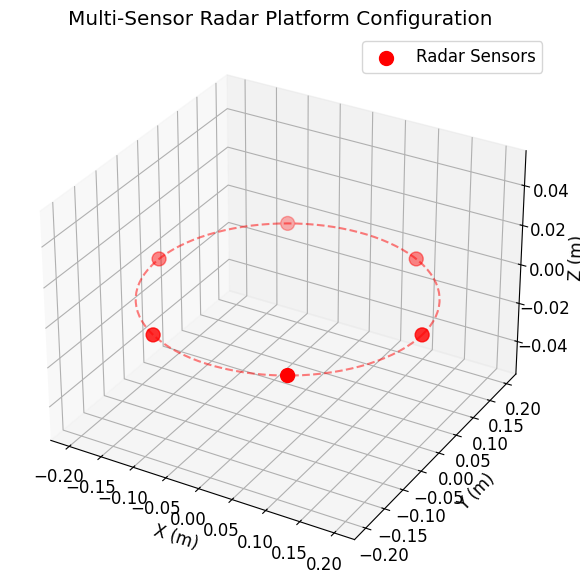

In [2]:
# Part 2: Sensor and System Configuration
class SensorPlatform:
    def __init__(self, radius=0.2, num_sensors=6, fc=24e9):
        self.radius = radius
        self.num_sensors = num_sensors
        self.fc = fc  # Carrier frequency in Hz
        self.c = 3e8  # Speed of light m/s
        self.lambda_radar = self.c / self.fc

        # Create circular sensor array
        angles = np.linspace(0, 2*np.pi, num_sensors, endpoint=False)
        self.positions = np.column_stack([
            radius * np.cos(angles),
            radius * np.sin(angles),
            np.zeros(num_sensors)  # All sensors in xy-plane
        ])

    def plot_sensors(self, ax):
        """Plot sensor positions on a 3D axis"""
        ax.scatter(self.positions[:, 0], self.positions[:, 1], self.positions[:, 2],
                  c='red', s=100, marker='o', label='Radar Sensors')
        # Draw circle
        circle_angles = np.linspace(0, 2*np.pi, 100)
        circle_x = self.radius * np.cos(circle_angles)
        circle_y = self.radius * np.sin(circle_angles)
        ax.plot(circle_x, circle_y, np.zeros(100), 'r--', alpha=0.5)
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.legend()

# Initialize sensor platform
sensor_platform = SensorPlatform()
print(f"Sensor platform configured:")
print(f"- Number of sensors: {sensor_platform.num_sensors}")
print(f"- Radar wavelength: {sensor_platform.lambda_radar:.4f} m")
print(f"- Sensor positions:\n{sensor_platform.positions}")

# Visualize sensor platform
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sensor_platform.plot_sensors(ax)
plt.title('Multi-Sensor Radar Platform Configuration')
plt.tight_layout()
plt.show()

# Part 2: Doppler Measurement Model and True Trajectory

In [3]:
# Part 3: Doppler Measurement Model and True Trajectory
class DopplerMeasurementModel:
    def __init__(self, sensor_platform):
        self.sensors = sensor_platform
        self.lambda_radar = sensor_platform.lambda_radar

    def h(self, state):
        """
        Nonlinear measurement function - Doppler shift for each sensor
        state: [px, py, pz, vx, vy, vz]
        returns: Doppler shifts for all sensors
        """
        position = state[:3]
        velocity = state[3:]

        doppler_shifts = []
        for sensor_pos in self.sensors.positions:
            # Vector from sensor to target
            relative_vec = sensor_pos - position
            distance = np.linalg.norm(relative_vec)

            # Avoid division by zero
            if distance < 1e-6:
                distance = 1e-6

            # Radial velocity component
            radial_velocity = np.dot(relative_vec, velocity) / distance

            # Doppler shift formula
            doppler_shift = (2 / self.lambda_radar) * radial_velocity
            doppler_shifts.append(doppler_shift)

        return np.array(doppler_shifts)

    def H_jacobian(self, state):
        """
        Analytical Jacobian of measurement function h(x)
        This is the linearization for EKF
        """
        px, py, pz, vx, vy, vz = state
        H = np.zeros((self.sensors.num_sensors, 6))

        for i, sensor_pos in enumerate(self.sensors.positions):
            sx, sy, sz = sensor_pos
            dx = sx - px
            dy = sy - py
            dz = sz - pz

            r = np.sqrt(dx**2 + dy**2 + dz**2)
            r3 = r**3

            # Partial derivatives for position components
            H[i, 0] = (2/self.lambda_radar) * (vx/r - dx*(dx*vx + dy*vy + dz*vz)/r3)
            H[i, 1] = (2/self.lambda_radar) * (vy/r - dy*(dx*vx + dy*vy + dz*vz)/r3)
            H[i, 2] = (2/self.lambda_radar) * (vz/r - dz*(dx*vx + dy*vy + dz*vz)/r3)

            # Partial derivatives for velocity components
            H[i, 3] = (2/self.lambda_radar) * (dx/r)
            H[i, 4] = (2/self.lambda_radar) * (dy/r)
            H[i, 5] = (2/self.lambda_radar) * (dz/r)

        return H

# Create measurement model
measurement_model = DopplerMeasurementModel(sensor_platform)

# Define true initial state (from paper Table 2)
true_initial_state = np.array([0.833, 0.111, 0.092, -0.75, -0.125, -0.018])

# Test the measurement model
test_doppler = measurement_model.h(true_initial_state)
print("Doppler measurement model test:")
print(f"True initial state: {true_initial_state}")
print(f"Predicted Doppler shifts: {test_doppler} Hz")

# Test Jacobian
test_jacobian = measurement_model.H_jacobian(true_initial_state)
print(f"\nJacobian shape: {test_jacobian.shape}")
print("First row of Jacobian:", test_jacobian[0])

Doppler measurement model test:
True initial state: [ 0.833  0.111  0.092 -0.75  -0.125 -0.018]
Predicted Doppler shifts: [120.8313566  117.3252393  118.11672308 121.23059166 120.35763895
 118.64190607] Hz

Jacobian shape: (6, 6)
First row of Jacobian: [  -3.36672253    1.01566121   21.93909749 -156.00492111  -27.35631318
  -22.67370101]


# Part 3: EKF Implementation

In [4]:
# Part 4: EKF Implementation
class ExtendedKalmanFilter:
    def __init__(self, initial_state, initial_covariance, F, Q, R, measurement_model):
        self.x = initial_state.copy()  # State estimate [px, py, pz, vx, vy, vz]
        self.P = initial_covariance.copy()  # Estimation error covariance
        self.F = F.copy()  # State transition matrix
        self.Q = Q.copy()  # Process noise covariance
        self.R = R.copy()  # Measurement noise covariance
        self.measurement_model = measurement_model

    def predict(self, dt=None):
        """Prediction step"""
        # Update state transition matrix if dt is provided
        if dt is not None:
            self._update_transition_matrix(dt)

        # Predict state
        self.x = self.F @ self.x

        # Predict covariance
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        """Update step with measurement z"""
        # Predict measurement
        z_pred = self.measurement_model.h(self.x)

        # Calculate innovation
        innovation = z - z_pred

        # Compute Jacobian
        H = self.measurement_model.H_jacobian(self.x)

        # Innovation covariance
        S = H @ self.P @ H.T + self.R

        # Kalman gain
        K = self.P @ H.T @ inv(S)

        # Update state estimate
        self.x = self.x + K @ innovation

        # Update covariance (Joseph form for stability)
        I = np.eye(len(self.x))
        self.P = (I - K @ H) @ self.P @ (I - K @ H).T + K @ self.R @ K.T

        return innovation, S  # Return for NIS calculation

    def _update_transition_matrix(self, dt):
        """Update state transition matrix for given time step"""
        # Constant Velocity model transition matrix
        self.F = np.eye(6)
        self.F[0, 3] = dt
        self.F[1, 4] = dt
        self.F[2, 5] = dt

    def calculate_nis(self, innovation, S):
        """Calculate Normalized Innovation Squared"""
        return innovation.T @ inv(S) @ innovation

# Define system matrices
dt = 0.001  # 1ms sampling time

# State transition matrix (Constant Velocity model)
F = np.eye(6)
F[0, 3] = dt
F[1, 4] = dt
F[2, 5] = dt

# Process noise covariance (from paper)
sigma_p = 0.4  # Process noise standard deviation (m/s²)
G = np.array([[0.5*dt**2, 0.5*dt**2, 0.5*dt**2, dt, dt, dt]]).T
Q = G @ G.T * sigma_p**2

# Measurement noise covariance (from paper)
sigma_f = 0.4  # Doppler measurement noise standard deviation (Hz)
R = np.eye(sensor_platform.num_sensors) * sigma_f**2

print("EKF System Matrices:")
print(f"F (State Transition):\n{F}")
print(f"\nQ (Process Noise Covariance) shape: {Q.shape}")
print(f"R (Measurement Noise Covariance) shape: {R.shape}")

EKF System Matrices:
F (State Transition):
[[1.    0.    0.    0.001 0.    0.   ]
 [0.    1.    0.    0.    0.001 0.   ]
 [0.    0.    1.    0.    0.    0.001]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]

Q (Process Noise Covariance) shape: (6, 6)
R (Measurement Noise Covariance) shape: (6, 6)


# Part 4: MLE Initialization

In [5]:
# Part 5: MLE Initialization
class MLEInitializer:
    def __init__(self, sensor_platform, measurement_model):
        self.sensors = sensor_platform
        self.measurement_model = measurement_model

    def cost_function(self, candidate_x, measured_dopplers):
        """Cost function for MLE optimization"""
        predicted_dopplers = self.measurement_model.h(candidate_x)
        residuals = measured_dopplers - predicted_dopplers
        return np.sum(residuals**2)

    def initialize(self, measurement_buffer, initial_guess=None):
        """
        Perform MLE initialization using a buffer of measurements
        measurement_buffer: list of measurement vectors
        """
        if initial_guess is None:
            # Simple heuristic initial guess
            initial_guess = np.array([0.5, 0.0, 0.1, -0.5, 0.0, 0.0])

        # Average measurements over the buffer
        avg_measurements = np.mean(measurement_buffer, axis=0)

        # Define bounds for optimization (physical constraints)
        bounds = [
            (0.1, 2.0),    # px: reasonable range from sensors
            (-1.0, 1.0),   # py
            (-0.5, 0.5),   # pz
            (-2.0, 0.0),   # vx: approaching (negative)
            (-1.0, 1.0),   # vy
            (-1.0, 1.0)    # vz
        ]

        # Perform optimization
        result = minimize(
            self.cost_function,
            initial_guess,
            args=(avg_measurements,),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 1000}
        )

        if result.success:
            print("MLE Initialization successful!")
            print(f"Initial guess: {initial_guess}")
            print(f"MLE result: {result.x}")
            print(f"Cost: {result.fun}")
        else:
            print("MLE Initialization failed!")
            print(f"Message: {result.message}")

        return result.x

# Create MLE initializer
mle_initializer = MLEInitializer(sensor_platform, measurement_model)

print("MLE Initializer created successfully!")

MLE Initializer created successfully!


# Part 5: Simulation Setup and Data Generation

Simulation Parameters:
Total time: 1.0 s
Time step: 0.001 s
Number of steps: 1000
MLE buffer size: 10
True trajectory shape: (1000, 6)
Measurements shape: (1000, 6)


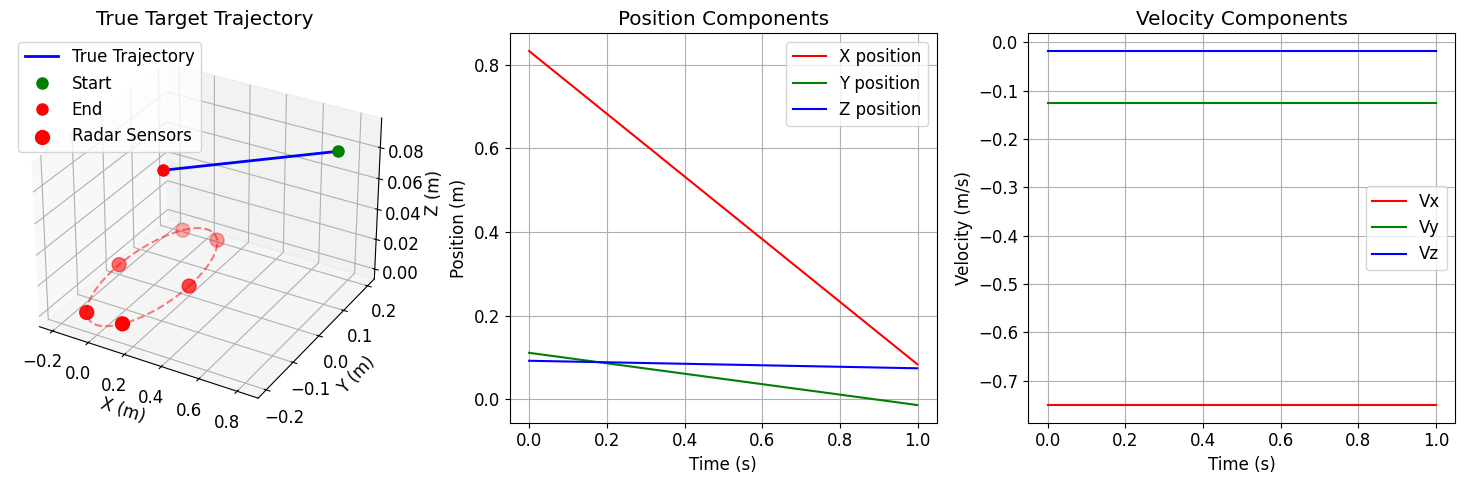

In [6]:
# Part 6: Simulation Setup and Data Generation
def simulate_true_trajectory(initial_state, num_steps, dt):
    """
    Simulate true target trajectory using Constant Velocity model
    """
    # State transition matrix for true dynamics
    F_true = np.eye(6)
    F_true[0, 3] = dt
    F_true[1, 4] = dt
    F_true[2, 5] = dt

    trajectory = [initial_state.copy()]
    current_state = initial_state.copy()

    for k in range(1, num_steps):
        # Perfect CV motion
        current_state = F_true @ current_state
        trajectory.append(current_state.copy())

    return np.array(trajectory)

def simulate_measurements(trajectory, measurement_model, R):
    """
    Generate noisy Doppler measurements along trajectory
    """
    measurements = []
    for state in trajectory:
        true_doppler = measurement_model.h(state)
        # Add Gaussian noise
        noise = np.random.multivariate_normal(np.zeros(R.shape[0]), R)
        noisy_measurement = true_doppler + noise
        measurements.append(noisy_measurement)

    return np.array(measurements)

# Simulation parameters
total_time = 1.0  # seconds
dt = 0.001  # 1ms sampling
num_steps = int(total_time / dt)
init_buffer_size = 10  # Number of measurements for MLE initialization

print(f"Simulation Parameters:")
print(f"Total time: {total_time} s")
print(f"Time step: {dt} s")
print(f"Number of steps: {num_steps}")
print(f"MLE buffer size: {init_buffer_size}")

# Generate true trajectory
true_trajectory = simulate_true_trajectory(true_initial_state, num_steps, dt)

# Generate measurements
measurements = simulate_measurements(true_trajectory, measurement_model, R)

print(f"True trajectory shape: {true_trajectory.shape}")
print(f"Measurements shape: {measurements.shape}")

# Plot true trajectory
fig = plt.figure(figsize=(15, 5))

# 3D trajectory
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(true_trajectory[:, 0], true_trajectory[:, 1], true_trajectory[:, 2],
         'b-', linewidth=2, label='True Trajectory')
ax1.plot([true_trajectory[0, 0]], [true_trajectory[0, 1]], [true_trajectory[0, 2]],
         'go', markersize=8, label='Start')
ax1.plot([true_trajectory[-1, 0]], [true_trajectory[-1, 1]], [true_trajectory[-1, 2]],
         'ro', markersize=8, label='End')
sensor_platform.plot_sensors(ax1)
ax1.set_title('True Target Trajectory')
ax1.legend()

# Position components
ax2 = fig.add_subplot(132)
time_axis = np.arange(num_steps) * dt
ax2.plot(time_axis, true_trajectory[:, 0], 'r-', label='X position')
ax2.plot(time_axis, true_trajectory[:, 1], 'g-', label='Y position')
ax2.plot(time_axis, true_trajectory[:, 2], 'b-', label='Z position')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position (m)')
ax2.set_title('Position Components')
ax2.legend()
ax2.grid(True)

# Velocity components
ax3 = fig.add_subplot(133)
ax3.plot(time_axis, true_trajectory[:, 3], 'r-', label='Vx')
ax3.plot(time_axis, true_trajectory[:, 4], 'g-', label='Vy')
ax3.plot(time_axis, true_trajectory[:, 5], 'b-', label='Vz')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Velocity (m/s)')
ax3.set_title('Velocity Components')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

# Part 6: Main Tracking Simulation

In [7]:
# Part 7: Main Tracking Simulation
print("Starting main tracking simulation...")

# Step 1: MLE Initialization using first few measurements
print("\nStep 1: MLE Initialization")
measurement_buffer = measurements[:init_buffer_size]
x0_ML = mle_initializer.initialize(measurement_buffer)

# Initial covariance (from paper, with some uncertainty)
P0 = np.eye(6) * 0.1

print(f"\nMLE Initial State: {x0_ML}")
print(f"True Initial State: {true_initial_state}")
print(f"Initial Error: {np.linalg.norm(x0_ML - true_initial_state):.4f}")

# Step 2: Initialize EKF
print("\nStep 2: EKF Initialization")
ekf = ExtendedKalmanFilter(x0_ML, P0, F, Q, R, measurement_model)

# Step 3: Main tracking loop
print("\nStep 3: Running EKF tracking...")
estimated_states = [x0_ML.copy()]
nis_history = []
position_errors = []
velocity_errors = []

for k in range(init_buffer_size, num_steps):
    # EKF Predict Step
    ekf.predict(dt)

    # EKF Update Step
    innovation, S = ekf.update(measurements[k])

    # Calculate NIS
    nis = ekf.calculate_nis(innovation, S)
    nis_history.append(nis)

    # Store results
    estimated_states.append(ekf.x.copy())

    # Calculate errors
    pos_error = np.linalg.norm(ekf.x[:3] - true_trajectory[k, :3])
    vel_error = np.linalg.norm(ekf.x[3:] - true_trajectory[k, 3:])
    position_errors.append(pos_error)
    velocity_errors.append(vel_error)

    if k % 100 == 0:  # Print progress every 100 steps
        print(f"Step {k}/{num_steps}, Pos Error: {pos_error:.4f} m, Vel Error: {vel_error:.4f} m/s")

estimated_states = np.array(estimated_states)

print("\nSimulation completed successfully!")
print(f"Final position estimate: {estimated_states[-1, :3]}")
print(f"Final true position: {true_trajectory[-1, :3]}")
print(f"Final position error: {position_errors[-1]:.4f} m")

Starting main tracking simulation...

Step 1: MLE Initialization
MLE Initialization successful!
Initial guess: [ 0.5  0.   0.1 -0.5  0.   0. ]
MLE result: [ 0.82414317  0.10849611 -0.0245064  -0.75282456 -0.12604187 -0.18371944]
Cost: 0.0023611372181401896

MLE Initial State: [ 0.82414317  0.10849611 -0.0245064  -0.75282456 -0.12604187 -0.18371944]
True Initial State: [ 0.833  0.111  0.092 -0.75  -0.125 -0.018]
Initial Error: 0.2028

Step 2: EKF Initialization

Step 3: Running EKF tracking...
Step 100/1000, Pos Error: 0.8626 m, Vel Error: 0.7911 m/s
Step 200/1000, Pos Error: 0.6357 m, Vel Error: 0.7445 m/s
Step 300/1000, Pos Error: 0.6673 m, Vel Error: 0.7510 m/s
Step 400/1000, Pos Error: 0.5708 m, Vel Error: 0.8811 m/s
Step 500/1000, Pos Error: 0.4238 m, Vel Error: 0.7522 m/s
Step 600/1000, Pos Error: 0.3875 m, Vel Error: 0.7634 m/s
Step 700/1000, Pos Error: 0.3798 m, Vel Error: 0.7887 m/s
Step 800/1000, Pos Error: 0.3426 m, Vel Error: 0.7546 m/s
Step 900/1000, Pos Error: 0.3252 m, Ve

# Part 7: Results Visualization and Analysis

Generating results visualization...
Adjusted array lengths:
results_time: 990
estimated_states: 990
position_errors: 990
velocity_errors: 990
nis_history: 990

Performance Summary:
Position RMSE: 0.5361 m
Velocity RMSE: 0.7637 m/s


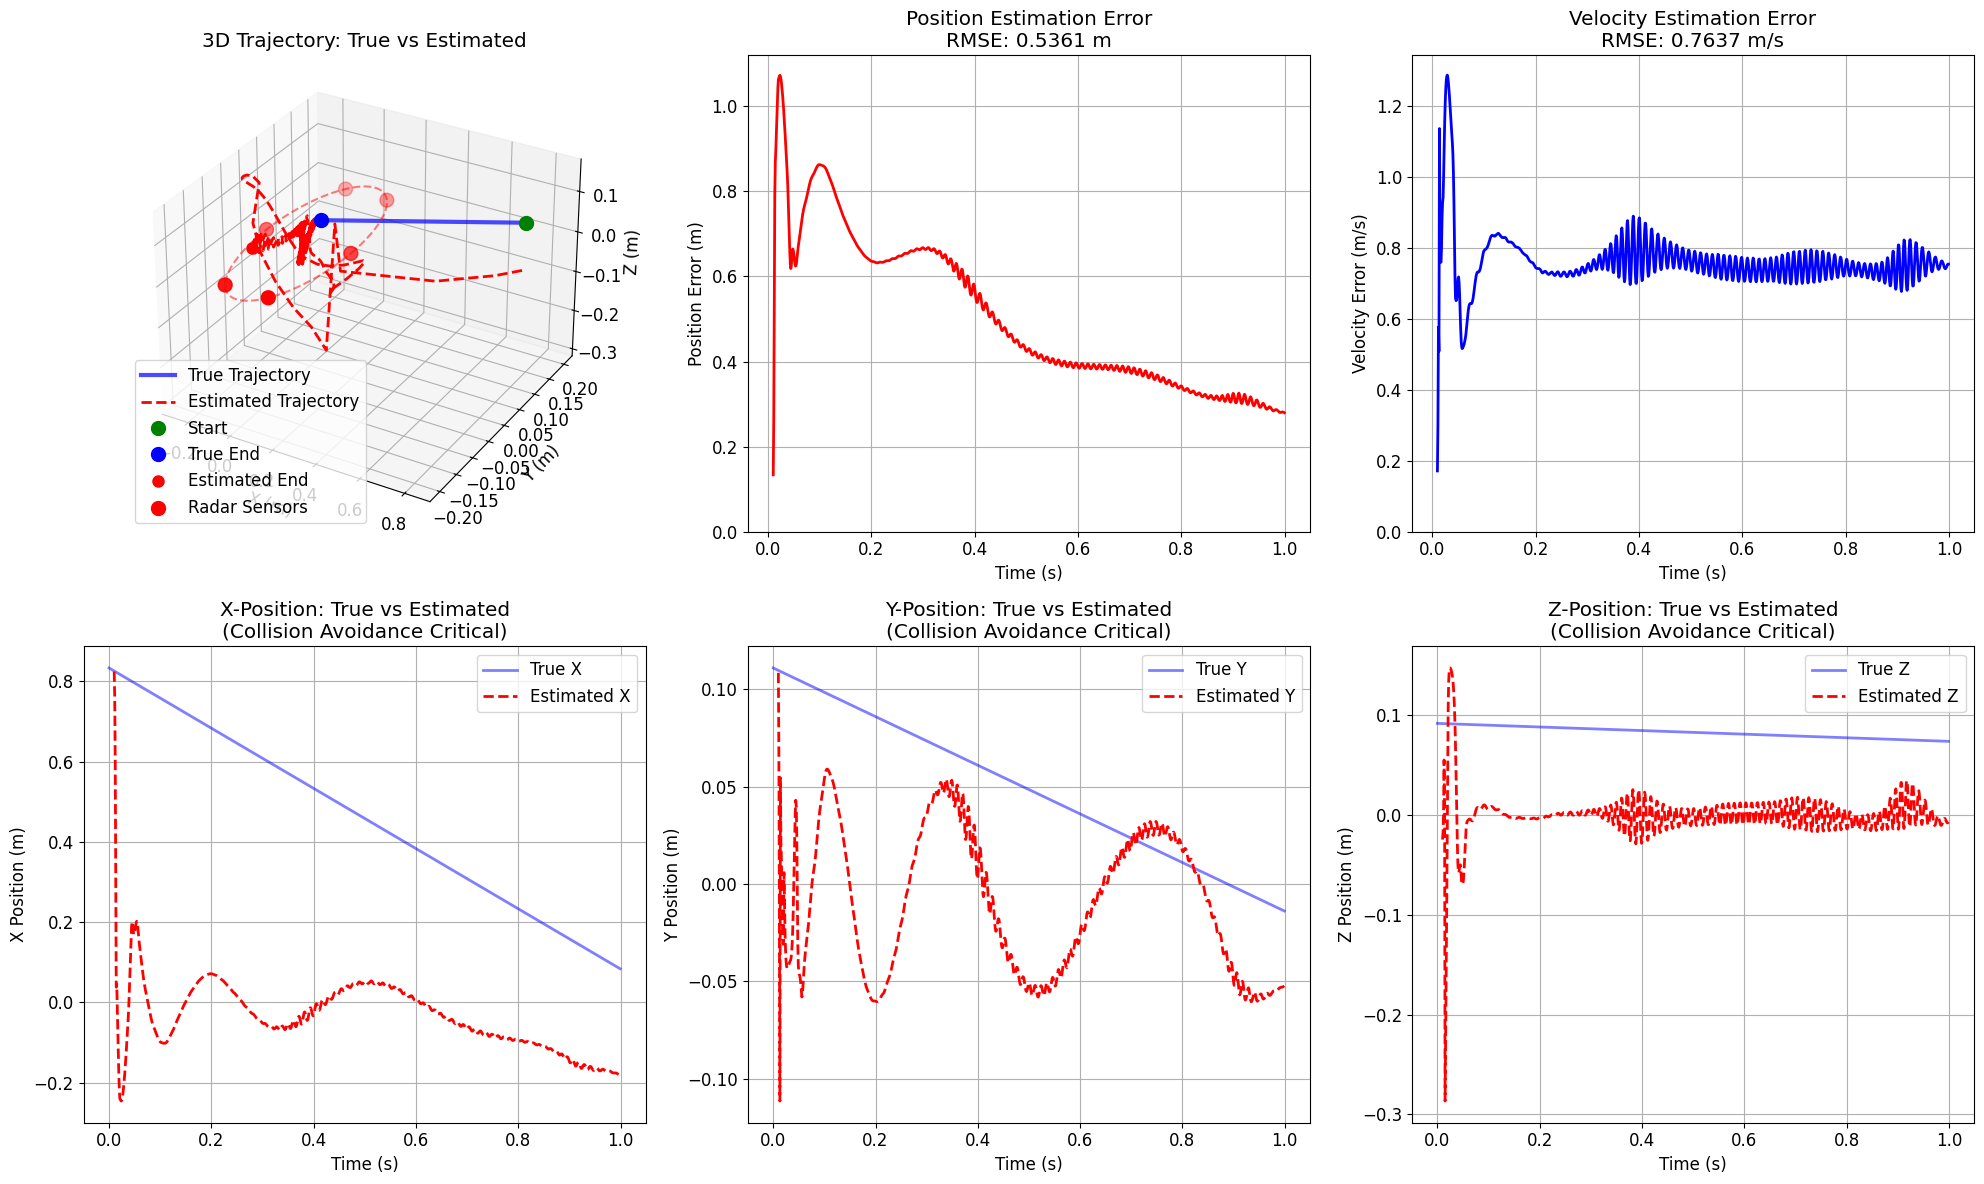


Final State Comparison:
Parameter  True       Estimated    Error     
---------------------------------------------
X          0.0912     -0.1813      0.2726    
Y          -0.0126    -0.0524      0.0398    
Z          0.0742     -0.0068      0.0810    
Vx         -0.7500    -0.0081      0.7419    
Vy         -0.1250    0.0076       0.1326    
Vz         -0.0180    0.0009       0.0189    

Additional Metrics:
Final Position Error: 0.2871 m
Final Velocity Error: 0.7539 m/s
Tracking Duration: 0.999 seconds
Number of Tracking Steps: 990


In [16]:

print("Generating results visualization...")

# Create time axis for results (after initialization period)
# Note: estimated_states starts from init_buffer_size, but we need to align time properly
results_time = time_axis[init_buffer_size:len(estimated_states) + init_buffer_size]

# Make sure arrays have same length
min_length = min(len(results_time), len(estimated_states))
results_time = results_time[:min_length]
estimated_states = estimated_states[:min_length]
position_errors = position_errors[:min_length]
velocity_errors = velocity_errors[:min_length]
nis_history = nis_history[:min_length]

print(f"Adjusted array lengths:")
print(f"results_time: {len(results_time)}")
print(f"estimated_states: {len(estimated_states)}")
print(f"position_errors: {len(position_errors)}")
print(f"velocity_errors: {len(velocity_errors)}")
print(f"nis_history: {len(nis_history)}")

# Calculate RMSE
position_rmse = np.sqrt(np.mean(np.array(position_errors)**2))
velocity_rmse = np.sqrt(np.mean(np.array(velocity_errors)**2))

print(f"\nPerformance Summary:")
print(f"Position RMSE: {position_rmse:.4f} m")
print(f"Velocity RMSE: {velocity_rmse:.4f} m/s")

# Create comprehensive results plot
fig = plt.figure(figsize=(20, 12))

# Plot 1: 3D Trajectory Comparison
ax1 = fig.add_subplot(231, projection='3d')
# True trajectory (full length)
ax1.plot(true_trajectory[:, 0], true_trajectory[:, 1], true_trajectory[:, 2],
         'b-', linewidth=3, label='True Trajectory', alpha=0.7)
# Estimated trajectory
ax1.plot(estimated_states[:, 0], estimated_states[:, 1], estimated_states[:, 2],
         'r--', linewidth=2, label='Estimated Trajectory')
# Start and end points
ax1.plot([true_trajectory[0, 0]], [true_trajectory[0, 1]], [true_trajectory[0, 2]],
         'go', markersize=10, label='Start')
ax1.plot([true_trajectory[-1, 0]], [true_trajectory[-1, 1]], [true_trajectory[-1, 2]],
         'bo', markersize=10, label='True End')
ax1.plot([estimated_states[-1, 0]], [estimated_states[-1, 1]], [estimated_states[-1, 2]],
         'ro', markersize=8, label='Estimated End')
sensor_platform.plot_sensors(ax1)
ax1.set_title('3D Trajectory: True vs Estimated')
ax1.legend()

# Plot 2: Position Errors
ax2 = fig.add_subplot(232)
ax2.plot(results_time, position_errors, 'r-', linewidth=2)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position Error (m)')
ax2.set_title(f'Position Estimation Error\nRMSE: {position_rmse:.4f} m')
ax2.grid(True)
ax2.set_ylim(bottom=0)

# Plot 3: Velocity Errors
ax3 = fig.add_subplot(233)
ax3.plot(results_time, velocity_errors, 'b-', linewidth=2)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Velocity Error (m/s)')
ax3.set_title(f'Velocity Estimation Error\nRMSE: {velocity_rmse:.4f} m/s')
ax3.grid(True)
ax3.set_ylim(bottom=0)

# Plot 4: X-Position Comparison (most important for collision avoidance)
ax4 = fig.add_subplot(234)
# Plot full true trajectory for context
ax4.plot(time_axis, true_trajectory[:, 0], 'b-', linewidth=2, label='True X', alpha=0.5)
# Plot estimated trajectory (after initialization)
ax4.plot(results_time, estimated_states[:, 0], 'r--', linewidth=2, label='Estimated X')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('X Position (m)')
ax4.set_title('X-Position: True vs Estimated\n(Collision Avoidance Critical)')
ax4.legend()
ax4.grid(True)

# Plot 5: Y-Position Comparison (most important for collision avoidance)
ax5 = fig.add_subplot(235)
# Plot full true trajectory for context
ax5.plot(time_axis, true_trajectory[:, 1], 'b-', linewidth=2, label='True Y', alpha=0.5)
# Plot estimated trajectory (after initialization)
ax5.plot(results_time, estimated_states[:, 1], 'r--', linewidth=2, label='Estimated Y')
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Y Position (m)')
ax5.set_title('Y-Position: True vs Estimated\n(Collision Avoidance Critical)')
ax5.legend()
ax5.grid(True)

# Plot 6: Z-Position Comparison (most important for collision avoidance)
ax6 = fig.add_subplot(236)
# Plot full true trajectory for context
ax6.plot(time_axis, true_trajectory[:, 2], 'b-', linewidth=2, label='True Z', alpha=0.5)
# Plot estimated trajectory (after initialization)
ax6.plot(results_time, estimated_states[:, 2], 'r--', linewidth=2, label='Estimated Z')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Z Position (m)')
ax6.set_title('Z-Position: True vs Estimated\n(Collision Avoidance Critical)')
ax6.legend()
ax6.grid(True)

plt.tight_layout()
plt.show()

# Print final detailed comparison
print("\nFinal State Comparison:")
print(f"{'Parameter':<10} {'True':<10} {'Estimated':<12} {'Error':<10}")
print("-" * 45)
params = ['X', 'Y', 'Z', 'Vx', 'Vy', 'Vz']
for i, param in enumerate(params):
    true_val = true_trajectory[len(estimated_states)-1, i]  # Use corresponding true state
    est_val = estimated_states[-1, i]
    error = abs(true_val - est_val)
    print(f"{param:<10} {true_val:<10.4f} {est_val:<12.4f} {error:<10.4f}")


# Additional performance metrics
print(f"\nAdditional Metrics:")
print(f"Final Position Error: {np.linalg.norm(true_trajectory[min_length-1, :3] - estimated_states[-1, :3]):.4f} m")
print(f"Final Velocity Error: {np.linalg.norm(true_trajectory[min_length-1, 3:] - estimated_states[-1, 3:]):.4f} m/s")
print(f"Tracking Duration: {results_time[-1]:.3f} seconds")
print(f"Number of Tracking Steps: {len(estimated_states)}")